# CS 445 Course Project

Final Project: https://docs.google.com/document/d/11s9vB9TJSIP3EbcTtzcrFQ2U8Fh18c8LzvDqWWyYFV8/edit#

## Setup

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial import Delaunay

In [2]:
# #Brayden
datadir = "/Users/braydenturner/projects/MCS/cs445/course_project/" 

In [3]:
# #Caleb
# datadir = "./CS445_CourseProject"

In [4]:
# %matplotlib notebook
%matplotlib widget

# Load Images

In [52]:
class Image:
    def __init__(self, path):
        self.image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB).astype('double') / 255.0

In [104]:
img1 = Image('images/male.jpg') 
img2 = Image('images/female.jpg')

In [105]:
# Set images to same width and height

print(img1.image.shape)
print(img2.image.shape)

if (img1.image.shape[0] < img2.image.shape[0]):
    dim = (img1.image.shape[1], img1.image.shape[0])
    
    img2.image = cv2.resize(img2.image, dim, interpolation = cv2.INTER_AREA)
    
else:
    dim = (img2.image.shape[1], img2.image.shape[0])
    img1.image = cv2.resize(img1.image, dim, interpolation = cv2.INTER_AREA)
    
print(img1.image.shape)
print(img2.image.shape)

(950, 800, 3)
(408, 381, 3)
(408, 381, 3)
(408, 381, 3)


## Point Correspondence

In [106]:
def specify_corresponding_points(img, clicked = None):
    '''
    img: input image
    clicked: ??
    return: clicked: Array of shape 2xP (number of points clicked)
            clicked[0]: array of length P containing the x coordinates
            clicked[1]: array of length P contraining y coordinates
    '''
    fig = plt.figure()
    if clicked:
        num = len(clicked[0])
        fig.set_label(f'Choose {num} corresponding points on image. Press q to quit')
    else:
        fig.set_label('Choose points on image. Press q to quit')
    plt.axis('off')
    plt.imshow(img)
    xs = []
    ys = []
    clicked = [] #CONCERN: Do we want this to be nested in the if clicked statement? 
#                          #or is the goal to reset the clicked array?

    def on_mouse_pressed(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)
        
        counter = len(xs)
        
        plt.plot(x, y, "r+")
        plt.text(x + 5, y + 5, counter, color="red")

    def onclose(event):
        clicked.append(xs)
        clicked.append(ys)
        
    def key_press(event):
        if event.key == 'q':
            print("Quitting")
            clicked.append(xs)
            clicked.append(ys)
            plt.close(fig)
            
        
        
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    fig.canvas.mpl_connect('close_event', onclose)
    fig.canvas.mpl_connect('key_press_event', key_press)
    return clicked

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


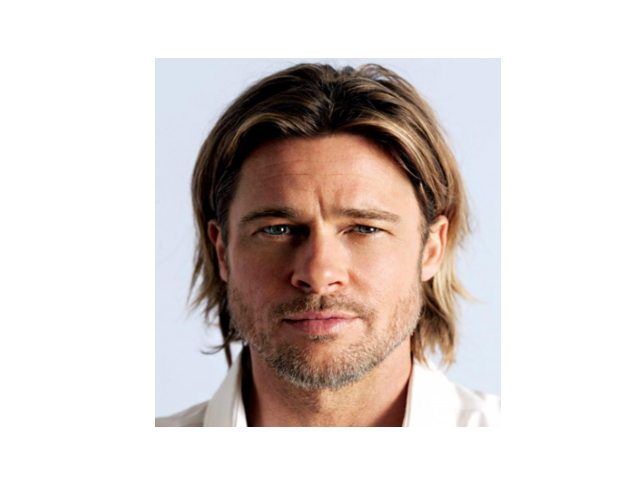

In [107]:
img1.pts = specify_corresponding_points(img1.image)

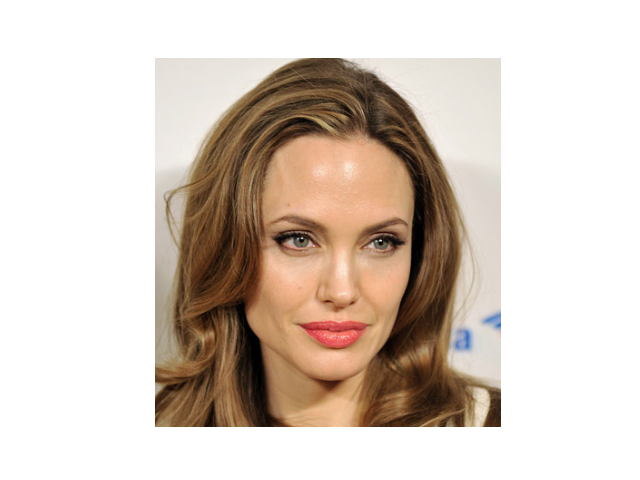

In [108]:
img2.pts = specify_corresponding_points(img2.image, img1.pts)

In [85]:
# Assert we have equal number of points
assert len(img1.pts) == len(img2.pts) and len(img1.pts[0]) == len(img2.pts[0])  and len(img1.pts[1]) == len(img2.pts[1])

## Triangulation Mesh

In [86]:
# convert to list of (x,y) touples for each point for use in scipy.spatial.Delaunay()
def toPtArray(pts, h, w):
    numPts = len(pts[0])
    points = np.zeros((numPts + 4, 2)) # add 4 points for 4 corners
    print(numPts)
    for i in range(len(pts[1])):
        points[i][0] = pts[0][i]
        points[i][1] = pts[1][i]

    #Add the 4 corners
    points[numPts][0] = 0
    points[numPts][1] = 0
    points[numPts+1][0] = 0
    points[numPts+1][1] = h
    points[numPts+2][0] = w
    points[numPts+2][1] = 0
    points[numPts+3][0] = w
    points[numPts+3][1] = h
    return points

In [87]:
# print(img1.pts)

In [88]:
pts1 = toPtArray(img1.pts, img1.image.shape[0], img1.image.shape[1])
pts2 = toPtArray(img2.pts, img2.image.shape[0], img2.image.shape[1])


9
9


In [89]:
tri1 = Delaunay(pts1)

# tri2 = Delaunay(pts2)

In [90]:
def display_triangulation(tri, pts, img):
    fig1 = plt.figure()
    plt.imshow(img.image)
    plt.triplot(pts[:,0], pts[:,1], tri.simplices)
    plt.plot(pts[:,0], pts[:,1], 'o')
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


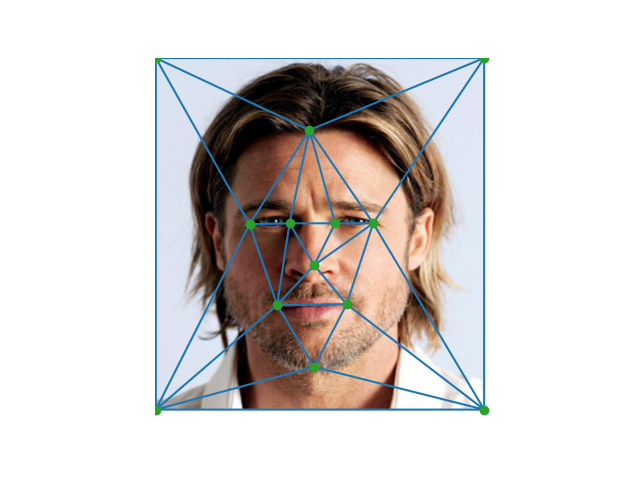

In [91]:
display_triangulation(tri1, pts1, img1)

The pts in pts1 and pts2 will be matched up so long as when clicking the points they are tagged in corresponding order. By simply taking the Delaunay of the first image and using those same simplices with the points for imag 2 we have a matching triangle mesh for both images. 

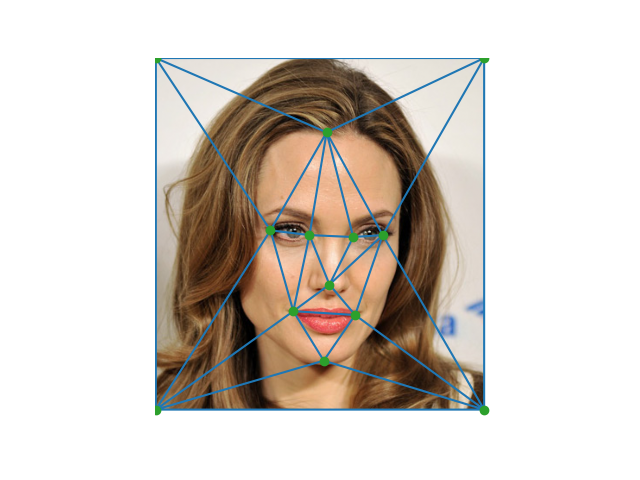

In [92]:
display_triangulation(tri1, pts2, img2)

In [93]:
pts1.shape

(13, 2)

The different attributes of the Delaunay can be found here: 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html
What we still need to do is create some sort of correlation between the triangles of one and the triangles of the other according to Lect. 6.1.3 time: 4:39
That is probably easiest if we choose images with high correspondance to start 

Lecture notes (Apparently everyone is stealing the same stuff from Efros): 
https://www.seas.upenn.edu/~cse399b/Lectures/CSE399b-07-triangle.pdf

## Linear Interpolation

Equation for linear interpolation: P + t * (Q-P) : 0 < t < 1

In [94]:
def lin_intepolate(pts1, pts2, n_steps):
    '''
    Takes pt locations for image1 and image2, and number of steps desired and 
    returns an array containing each point at each step in the linear interpolation
    
inputs:
    pts1:     array- size: num_points x 2 - array containing 2D locs. starting point of each linear interpolation
    pts2:     array- size: num_points x 2 - array containing 2D locs. end point of each linear interpolation
    n_steps:  int: indicating number of steps along linear path for each point
return: 
    l_interp: array- size: n_steps x num_points x 2 
    [step_number, pt_number, x or y]
    '''
    assert n_steps > 1
    num_pts, _ = pts1.shape
    l_interp = np.zeros((n_steps, num_pts,2))
    for j in range(num_pts):
        for xy in range(2):
            p1 = pts1[j,xy]
            p2 = pts2[j,xy]
            for i in range(n_steps):
                l_interp[i,j,xy] = p1 + (p2 - p1) * (i / (n_steps-1))
                
            
    return l_interp

In [95]:
l = lin_intepolate(pts1, pts2, 3)

In [96]:
print(pts1)
print(l)

[[178.29869456  83.61686964]
 [108.75324002 192.90258393]
 [155.11687638 191.79868782]
 [208.10388937 191.79868782]
 [252.25973352 191.79868782]
 [183.81817508 240.37011639]
 [140.76622703 286.73375276]
 [221.35064261 285.62985665]
 [183.81817508 358.48699951]
 [  0.           0.        ]
 [  0.         408.        ]
 [381.           0.        ]
 [381.         408.        ]]
[[[178.29869456  83.61686964]
  [108.75324002 192.90258393]
  [155.11687638 191.79868782]
  [208.10388937 191.79868782]
  [252.25973352 191.79868782]
  [183.81817508 240.37011639]
  [140.76622703 286.73375276]
  [221.35064261 285.62985665]
  [183.81817508 358.48699951]
  [  0.           0.        ]
  [  0.         408.        ]
  [381.           0.        ]
  [381.         408.        ]]

 [[188.2337595   84.94155844]
  [120.89609716 196.43506494]
  [166.70778547 198.64285714]
  [218.59090235 199.74675325]
  [257.77921404 198.64285714]
  [192.64934391 251.62987013]
  [150.14934391 290.26623377]
  [226.31817508 291.

In [97]:
test1 = np.arange(0,20).reshape(10,2)
print(test1)
test2 = np.arange(2,22).reshape(10,2)
print(test2)


[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
[[ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]
 [20 21]]


In [98]:
# Just returns the original 2 
lin_intepolate(test1,test2, 2)

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.],
        [16., 17.],
        [18., 19.]],

       [[ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.],
        [16., 17.],
        [18., 19.],
        [20., 21.]]])

In [99]:
# Returns an extra step in the middle
lin_intepolate(test1,test2, 3)

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.],
        [16., 17.],
        [18., 19.]],

       [[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [11., 12.],
        [13., 14.],
        [15., 16.],
        [17., 18.],
        [19., 20.]],

       [[ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.],
        [16., 17.],
        [18., 19.],
        [20., 21.]]])

In [100]:
# Simple Morph
avg_pts = lin_intepolate(pts1,pts2, 3)[1]

In [101]:
print(avg_pts)

[[188.2337595   84.94155844]
 [120.89609716 196.43506494]
 [166.70778547 198.64285714]
 [218.59090235 199.74675325]
 [257.77921404 198.64285714]
 [192.64934391 251.62987013]
 [150.14934391 290.26623377]
 [226.31817508 291.92207792]
 [189.3376556  354.84415584]
 [  0.           0.        ]
 [  0.         408.        ]
 [381.           0.        ]
 [381.         408.        ]]


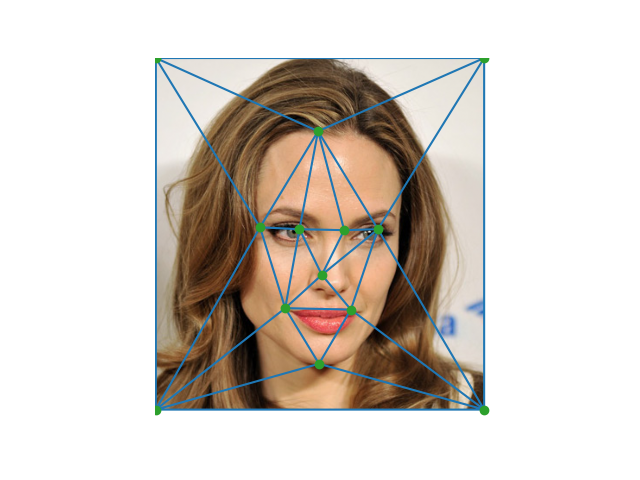

/var/folders/jc/85vy06cn6b13gcm4rcvz9_fw0000gq/T/ipykernel_61945/214599456.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


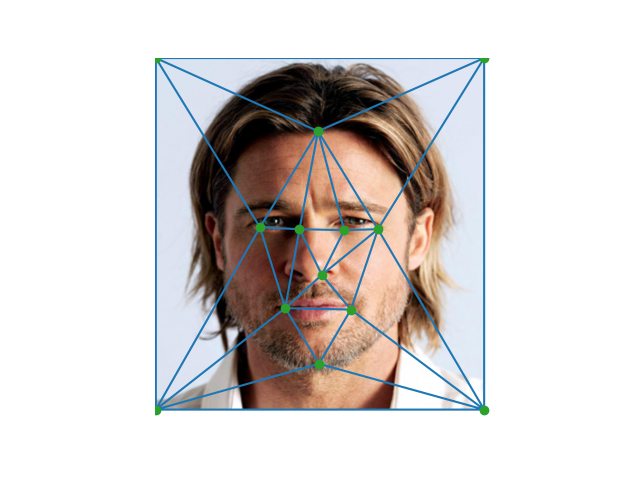

In [102]:
# Average points between the two
display_triangulation(tri1, avg_pts, img2)
display_triangulation(tri1, avg_pts, img1)

## Affine Transformation

Lesson 6.1.1 (2:45)
https://www.coursera.org/learn/cs-445/lecture/hdRaZ/lesson-6-1-1-image-morphing
![Lecture](images/notes.jpeg)

$ \begin{bmatrix}
x' \\
y' 
\end{bmatrix} =  
\begin{bmatrix}
a & b & c \\
d & e & f
\end{bmatrix}  
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}$

$
T = \begin{bmatrix}
a & b & c \\
d & e & f
\end{bmatrix}  
$

For the new triangles, we want to do an affine projection back to the two images (with interpolation) to grab the nearest pixel to the one we are filling and weighted average the two colors. To get the transformation matrix between the two triangles, we need to set up a system of linear equations and solve.

Once we have T above, we can map any point x, y in to x', y'. And to get the reverse projection, we can append a [0,0,1] row to T and take the inverse.


In [103]:

import scipy
from scipy.linalg import solve

def solve_transformation(tri1, tri2):
    
    # x and y below come from the old triangle we are morphing from
    A = np.array(
        [
            [x_a, y_a, 1, 0, 0, 0],
            [0, 0, 0, x_a, y_a, 1],
            [x_a, y_a, 1, 0, 0, 0],
            [0, 0, 0, x_b, y_b, 1],
            [x_c, y_c, 1, 0, 0, 0],
            [0, 0, 0, x_c, y_c, 1],
        ]
    )  
    
    # x' and y' below come from the triangle we are morphing to
    b = np.array(
        [
            x_prime_a,
            y_prime_a,
            x_prime_b,
            y_prime_b,
            x_prime_c,
            y_prime_c,
        ]
    )
    
    # Solve
    x = solve(A, b)
    
    # rehape in to 
    # [[a, b, c]
    #  [d, e, f]]
    x = x.reshape((2, 3))
    
    return x



## Tie It All Together